### Autoplotting vertical meshes

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Define some basic coordinate transformation functions
KM2M = 1.0e3
RADIUS_EARTH = 6371000

def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return azimuth, elevation, r

def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon

In [22]:
import meshio 

eaff = '/Users/jloveles/Documents/python/anatolia_block_models_coupling/data/mesh/mesh_test_eaf_78_002.msh'
mesh = dict()
meshobj = meshio.read(eaff)
mesh["file_name"] = eaff
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

# Expand mesh coordinates
mesh["lon1"] = mesh["points"][mesh["verts"][:, 0], 0]
mesh["lon2"] = mesh["points"][mesh["verts"][:, 1], 0]
mesh["lon3"] = mesh["points"][mesh["verts"][:, 2], 0]
mesh["lat1"] = mesh["points"][mesh["verts"][:, 0], 1]
mesh["lat2"] = mesh["points"][mesh["verts"][:, 1], 1]
mesh["lat3"] = mesh["points"][mesh["verts"][:, 2], 1]
mesh["dep1"] = mesh["points"][mesh["verts"][:, 0], 2]
mesh["dep2"] = mesh["points"][mesh["verts"][:, 1], 2]
mesh["dep3"] = mesh["points"][mesh["verts"][:, 2], 2]
print(np.shape(mesh["lon1"]))



(1914,)


In [23]:
#  Load model_meshes

folder_name = "./0000000343"
meshes = pd.read_csv(folder_name + "/model_meshes.csv")
# lon1_mesh = meshes.lon1.values
# lat1_mesh = meshes.lat1.values
# dep1_mesh = meshes.dep1.values
# lon2_mesh = meshes.lon2.values
# lat2_mesh = meshes.lat2.values
# dep2_mesh = meshes.dep2.values
# lon3_mesh = meshes.lon3.values
# lat3_mesh = meshes.lat3.values
# dep3_mesh = meshes.dep3.values

lon1_mesh = np.concatenate((meshes.lon1.values, mesh["lon1"]))
lat1_mesh = np.concatenate((meshes.lat1.values, mesh["lat1"]))
dep1_mesh = np.concatenate((meshes.dep1.values, mesh["dep1"]))
lon2_mesh = np.concatenate((meshes.lon2.values, mesh["lon2"]))
lat2_mesh = np.concatenate((meshes.lat2.values, mesh["lat2"]))
dep2_mesh = np.concatenate((meshes.dep2.values, mesh["dep2"]))
lon3_mesh = np.concatenate((meshes.lon3.values, mesh["lon3"]))
lat3_mesh = np.concatenate((meshes.lat3.values, mesh["lat3"]))
dep3_mesh = np.concatenate((meshes.dep3.values, mesh["dep3"]))

# Calculate element geometry
tri_leg1 = np.transpose([np.deg2rad(lon2_mesh - lon1_mesh), np.deg2rad(lat2_mesh - lat1_mesh), (1 + KM2M * dep2_mesh / RADIUS_EARTH) - (1 + KM2M * dep1_mesh / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(lon3_mesh - lon1_mesh), np.deg2rad(lat3_mesh - lat1_mesh), (1 + KM2M * dep3_mesh / RADIUS_EARTH) - (1 + KM2M * dep1_mesh / RADIUS_EARTH)])
norm_vec = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(norm_vec[:, 0], norm_vec[:, 1], norm_vec[:, 2])
strike = wrap2360(-np.rad2deg(azimuth))
dip = 90 - np.rad2deg(elevation)

In [ ]:


dip_dir = np.mean(np.deg2rad(strike[steep] + 90))
scale_factor = 10
new_lon1_mesh = lon1_mesh + np.sin(dip_dir)*np.rad2deg(np.abs(KM2M * dep1_mesh / RADIUS_EARTH))
new_lat1_mesh = lat1_mesh + np.cos(dip_dir)*np.rad2deg(np.abs(KM2M * dep1_mesh / RADIUS_EARTH))
new_lon2_mesh = lon2_mesh + np.sin(dip_dir)*np.rad2deg(np.abs(KM2M * dep2_mesh / RADIUS_EARTH))
new_lat2_mesh = lat2_mesh + np.cos(dip_dir)*np.rad2deg(np.abs(KM2M * dep2_mesh / RADIUS_EARTH))
new_lon3_mesh = lon3_mesh + np.sin(dip_dir)*np.rad2deg(np.abs(KM2M * dep3_mesh / RADIUS_EARTH))
new_lat3_mesh = lat3_mesh + np.cos(dip_dir)*np.rad2deg(np.abs(KM2M * dep3_mesh / RADIUS_EARTH))

lon1_mesh[steep] = new_lon1_mesh[steep]
lat1_mesh[steep] = new_lat1_mesh[steep]
lon2_mesh[steep] = new_lon2_mesh[steep]
lat2_mesh[steep] = new_lat2_mesh[steep]
lon3_mesh[steep] = new_lon3_mesh[steep]
lat3_mesh[steep] = new_lat3_mesh[steep]


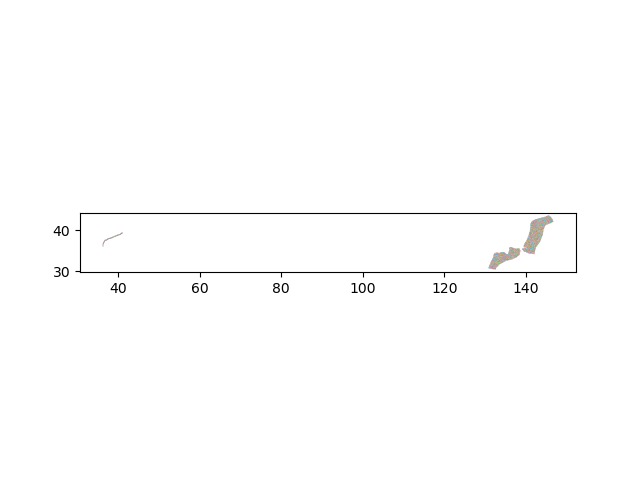

In [25]:
%matplotlib widget
fig, ax = plt.subplots()
for i in range(len(lon1_mesh)):
    pc = np.array([[lon1_mesh[i], lon2_mesh[i], lon3_mesh[i]], [lat1_mesh[i], lat2_mesh[i], lat3_mesh[i]]])
    ax.fill(pc[0, :], pc[1, :])
ax.set_aspect("equal")
plt.show()

In [32]:
fff = i*np.ones(len(dep3_mesh)).astype(int)